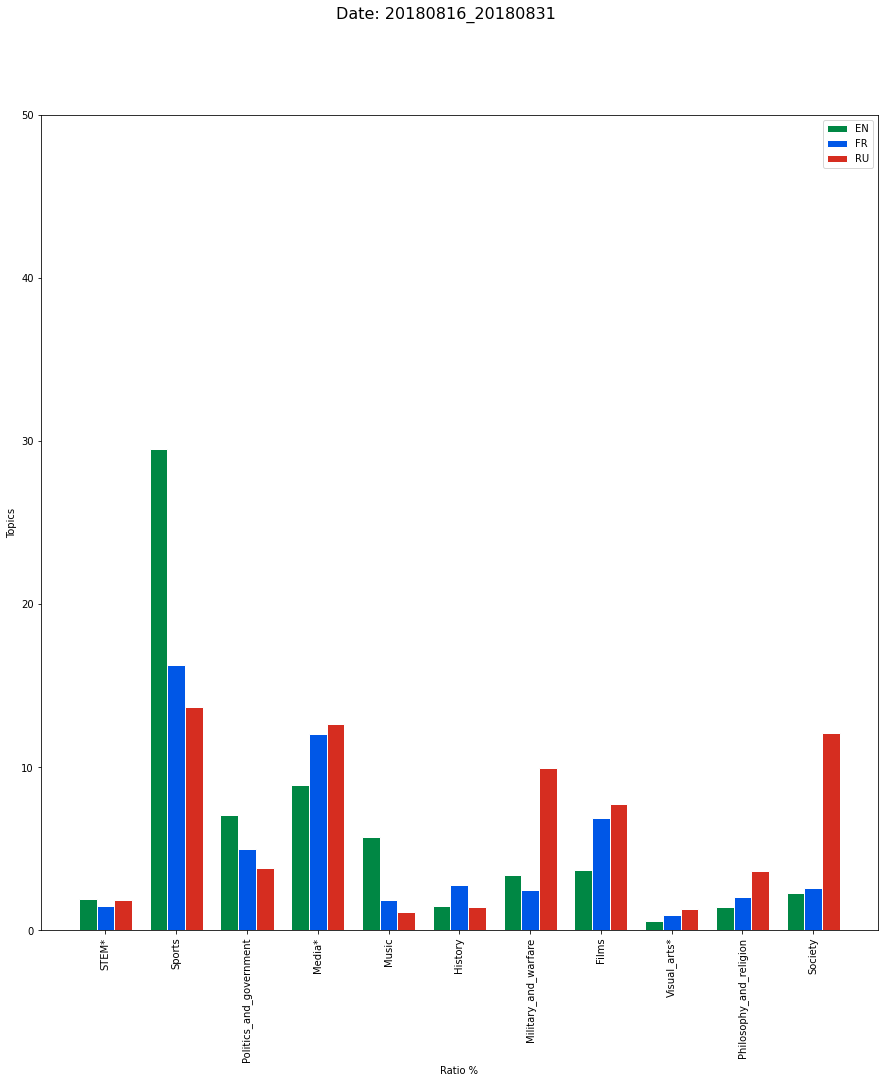

,Count,Ratio
Subtopic,,
Sports,8743.0,30.831893
Media*,2460.0,8.675107
Politics_and_government,2021.0,7.126988
North_America,1785.0,6.294742
Films,1261.0,4.446874
...,...,...
Central_Asia,5.0,0.017632
Southern_Africa,4.0,0.014106
Biography*,3.0,0.010579


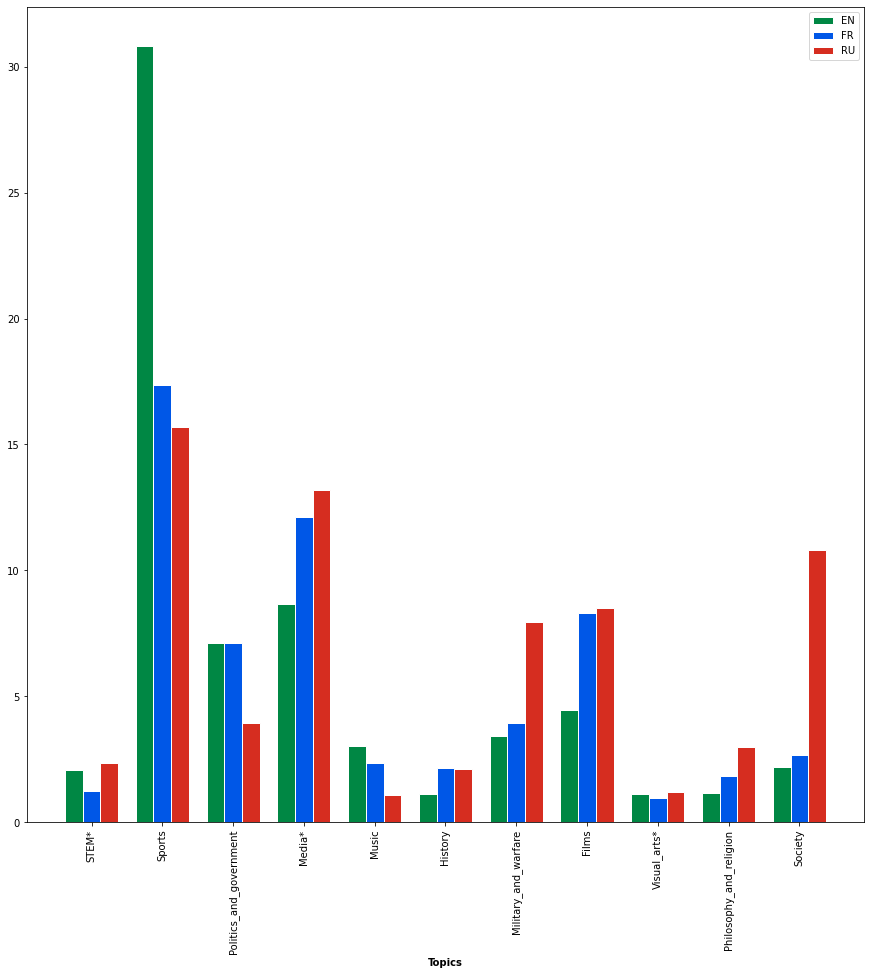

In [146]:
import IPython
import numpy as np
import networkx as nx
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import time
import community
from fonctions import *


### Parameters for the following pipeline ###

pd.set_option('mode.chained_assignment', None)

path_en = 'Results/EN/EN_'
path_fr = 'Results/FR/FR_'
path_ru = 'Results/RU/RU_'

list_date = ['20180816_20180831', '20180901_20180915', '20180916_20180930', '20181001_20181015', 
            '20181016_20181031', '20181101_20181115',  '20181116_20181130', '20181201_20181215',
            '20181216_20181231']

list_topic = ['STEM*', 'Sports', 'Politics_and_government', 'Media*', 'Music', 'History', 'Military_and_warfare',
             'Films', 'Visual_arts*', 'Philosophy_and_religion', 'Society']




def count_topics(date):
    
    count_en, count_fr, count_ru = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    

    df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
    df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
    df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')

    count_en = df_en[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_fr = df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_ru = df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum()

    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)

    return count_en.sort_values(by="Count", ascending=False), count_fr.sort_values(by="Count", ascending=False), count_ru.sort_values(by="Count", ascending=False)










def count_total_topics(list_date):
    
    count_en, count_fr, count_ru = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    for date in list_date:
            
        df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
        df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
        df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')

        count_en = count_en.add(df_en[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_fr = count_fr.add(df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_ru = count_ru.add(df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)

    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)

    return count_en.sort_values(by="Count", ascending=False), count_fr.sort_values(by="Count", ascending=False), count_ru.sort_values(by="Count", ascending=False)
    

    

def display_topics_comparison(ratio_en, ratio_fr, ratio_ru, list_topic):
    plt.figure(figsize=(15,15))

    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars_en, bars_fr, bars_ru = [], [], []

    for tp in list_topic:
        bars_en.append(list(ratio_en.loc[ratio_en.index.str.contains(tp)])[0])
        bars_fr.append(list(ratio_fr.loc[ratio_fr.index.str.contains(tp)])[0])
        bars_ru.append(list(ratio_ru.loc[ratio_ru.index.str.contains(tp)])[0])

    # Set position of bar on X axis
    r1 = np.arange(len(bars_en))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Make the plot
    plt.bar(r1, bars_en, color='#008744', width=barWidth, edgecolor='white', label='EN')
    plt.bar(r2, bars_fr, color='#0057e7', width=barWidth, edgecolor='white', label='FR')
    plt.bar(r3, bars_ru, color='#d62d20', width=barWidth, edgecolor='white', label='RU')

    # Add xticks on the middle of the group bars
    plt.xlabel('Topics', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars_en))], list_topic, rotation='vertical')
        
    # Create legend & Show graphic
    plt.legend()
    plt.show()

    
    

def barlist(n): 
    bars_en, bars_fr, bars_ru = [], [], []
    df_en, df_fr, df_ru = count_topics(list_date[n])
    for tp in list_topic:
            bars_en.append(list(df_en.loc[df_en.index.str.contains(tp), 'Ratio'].values)[0])
            bars_fr.append(list(df_fr.loc[df_fr.index.str.contains(tp), 'Ratio'].values)[0])
            bars_ru.append(list(df_ru.loc[df_ru.index.str.contains(tp), 'Ratio'].values)[0])
    return bars_en, bars_fr, bars_ru    
    
    
    
def topic_evolution(list_topic, list_date):
    fig= plt.figure(figsize=(15,15))
    barWidth = 0.25
    
    ax=plt.axes()
    ax.set_ylim(0, 50)
    
    n=len(list_date) #Number of frames
    
    bar_en, bar_fr, bar_ru = barlist(0)
    
    r1=range(len(bar_en))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    barcollection_en = plt.bar(r1, bar_en, color='#008744', width=barWidth, edgecolor='white', label='EN')
    barcollection_fr = plt.bar(r2, bar_fr, color='#0057e7', width=barWidth, edgecolor='white', label='FR')
    barcollection_ru = plt.bar(r3, bar_ru, color='#d62d20', width=barWidth, edgecolor='white', label='RU')
    
    plt.xticks([r + barWidth for r in range(len(list_topic))], list_topic, rotation='vertical')

    def animate(i):
        y_en, y_fr, y_ru = barlist(i)
        fig.suptitle('Date: ' + list_date[i], fontsize=16)
        for n, b in enumerate(barcollection_en):
            b.set_height(y_en[n])
        for n, b in enumerate(barcollection_fr):
            b.set_height(y_fr[n])
        for n, b in enumerate(barcollection_ru):
            b.set_height(y_ru[n])
        
    anim=FuncAnimation(fig, animate, repeat=True, blit=False, frames=n, interval=1000)

    plt.xlabel('Ratio %')
    plt.ylabel('Topics')
    plt.legend()
    plt.show()
    anim.save('bar.gif', writer='pillow')
    

    


topic_evolution(list_topic, list_date)    

 
    
    
    
    
    
    
    
date = '20180816_20180831'
    
count_en, count_fr, count_ru = count_total_topics(list_date)

display(count_en)

display_topics_comparison(count_en['Ratio'], count_fr['Ratio'], count_ru['Ratio'], list_topic)



<ipython-input-47-78724ce85dd2>:154: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


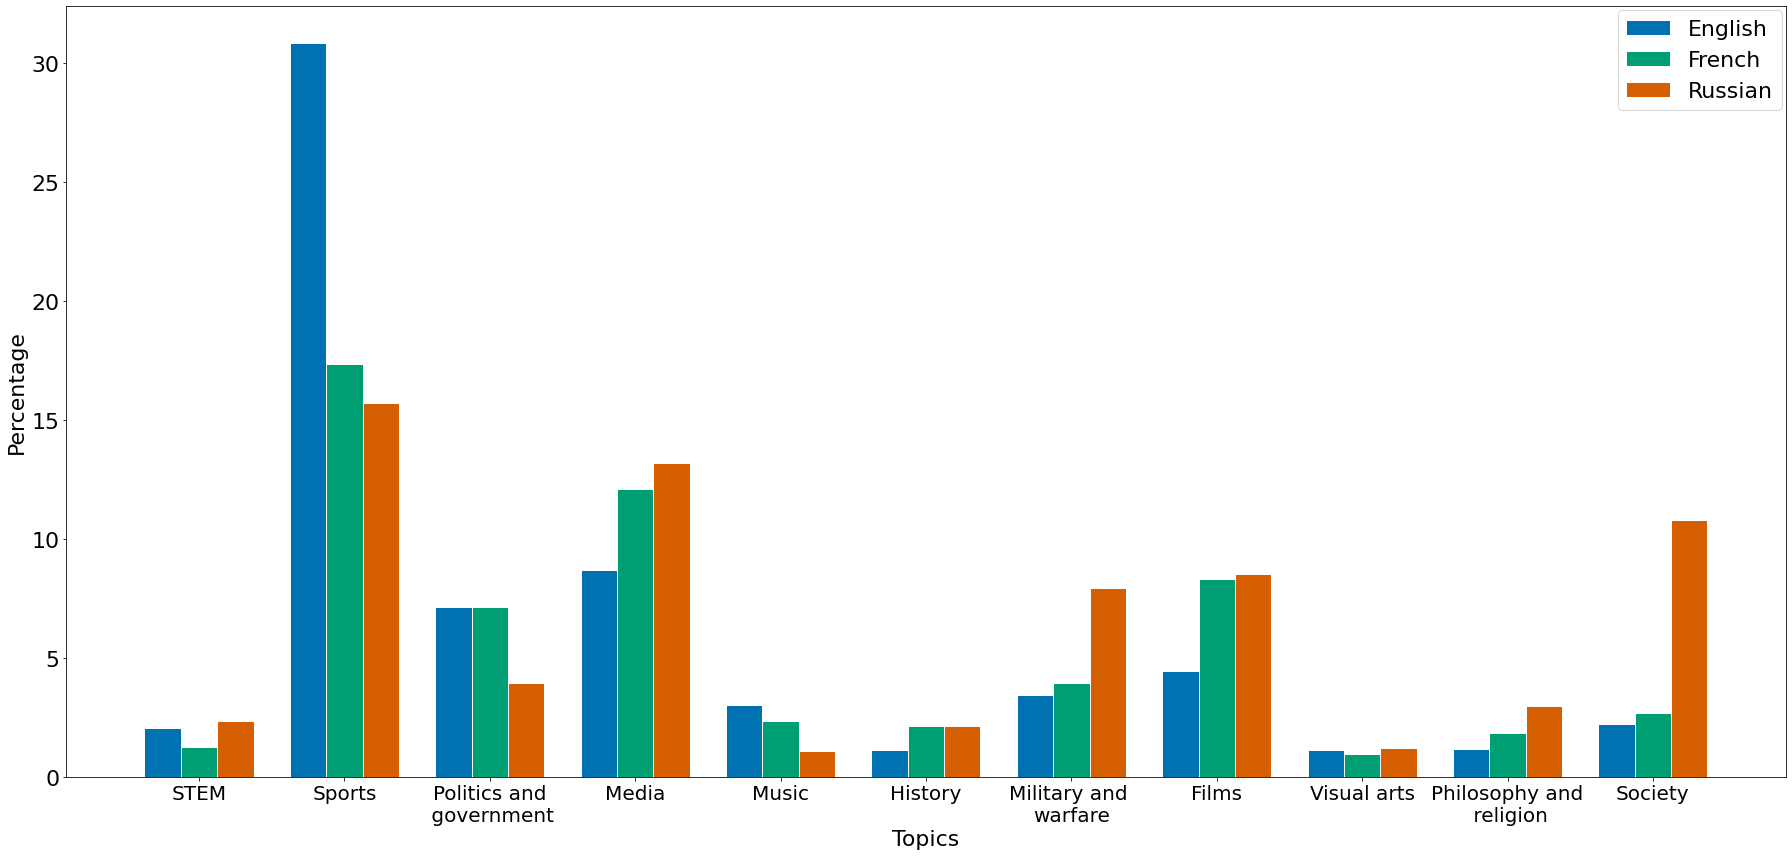

In [47]:
import IPython
import numpy as np
import networkx as nx
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import time
import community
from fonctions import *




### Volodymyr's layout parameters
plt.style.use('seaborn-colorblind')

from pylab import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['figure.figsize'] = 25, 12
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 22

   










### Parameters for the following pipeline ###

pd.set_option('mode.chained_assignment', None)

path_en = 'Results/EN/EN_'
path_fr = 'Results/FR/FR_'
path_ru = 'Results/RU/RU_'

list_date = ['20180816_20180831', '20180901_20180915', '20180916_20180930', '20181001_20181015', 
            '20181016_20181031', '20181101_20181115',  '20181116_20181130', '20181201_20181215',
            '20181216_20181231']

list_topic = ['STEM*', 'Sports', 'Politics_and_government', 'Media*', 'Music', 'History', 'Military_and_warfare',
             'Films', 'Visual_arts*', 'Philosophy_and_religion', 'Society']




def count_topics(date):
    
    count_en, count_fr, count_ru = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    

    df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
    df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
    df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')

    count_en = df_en[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_fr = df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_ru = df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum()

    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)

    return count_en.sort_values(by="Count", ascending=False), count_fr.sort_values(by="Count", ascending=False), count_ru.sort_values(by="Count", ascending=False)










def count_total_topics(list_date):
    
    count_en, count_fr, count_ru = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    for date in list_date:
            
        df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
        df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
        df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')

        count_en = count_en.add(df_en[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_fr = count_fr.add(df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_ru = count_ru.add(df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)

    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)

    return count_en.sort_values(by="Count", ascending=False), count_fr.sort_values(by="Count", ascending=False), count_ru.sort_values(by="Count", ascending=False)
    

    

def display_topics_comparison(ratio_en, ratio_fr, ratio_ru, list_topic):
    fig = plt.figure()

    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars_en, bars_fr, bars_ru = [], [], []

    for tp in list_topic:
        bars_en.append(list(ratio_en.loc[ratio_en.index.str.contains(tp)])[0])
        bars_fr.append(list(ratio_fr.loc[ratio_fr.index.str.contains(tp)])[0])
        bars_ru.append(list(ratio_ru.loc[ratio_ru.index.str.contains(tp)])[0])

    # Set position of bar on X axis
    r1 = np.arange(len(bars_en))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]


    
    plt.bar(r1, bars_en, width=barWidth, edgecolor='white', label='English')
    plt.bar(r2, bars_fr, width=barWidth, edgecolor='white', label='French')
    plt.bar(r3, bars_ru, width=barWidth, edgecolor='white', label='Russian')

    # Add xticks on the middle of the group bars
    
    
    
    # Making labels looks nicer
    for i in range(len(list_topic)): 
        list_topic[i] = list_topic[i].replace("_", " ")
        if ('*' in list_topic[i]):
            list_topic[i] = list_topic[i].replace("*", "")
    list_topic[2]=list_topic[2][0:12] + '\n' + list_topic[2][12:]
    list_topic[6]=list_topic[6][0:13] + '\n' + list_topic[6][13:]
    list_topic[9]=list_topic[9][0:14] + '\n' + list_topic[9][14:]
    
    plt.xticks([r + barWidth for r in range(len(bars_en))], list_topic, rotation='horizontal')
    
    plt.xlabel('Topics', fontsize=22)
    plt.ylabel('Percentage', fontsize=22)
    
    
    fig.tight_layout()
    # Create legend & Show graphic
    fig.legend(fontsize=22)
    fig.show()
    fig.savefig("topic_distribution.pdf", bbox_inches='tight')

    
    

def barlist(n): 
    bars_en, bars_fr, bars_ru = [], [], []
    df_en, df_fr, df_ru = count_topics(list_date[n])
    for tp in list_topic:
            bars_en.append(list(df_en.loc[df_en.index.str.contains(tp), 'Ratio'].values)[0])
            bars_fr.append(list(df_fr.loc[df_fr.index.str.contains(tp), 'Ratio'].values)[0])
            bars_ru.append(list(df_ru.loc[df_ru.index.str.contains(tp), 'Ratio'].values)[0])
    return bars_en, bars_fr, bars_ru    
    
    
    



    
    
    
    
date = '20180816_20180831'
    
count_en, count_fr, count_ru = count_total_topics(list_date)

display_topics_comparison(count_en['Ratio'], count_fr['Ratio'], count_ru['Ratio'], list_topic)


    
    
